In [1]:
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.emulators import gaussian_process
from swiftemulator.emulators import multi_gaussian_process
from swiftemulator.mean_models.linear import LinearMeanModel
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.special import erf
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.patheffects as path_effects
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
import illustris_python as il
import pickle
from scipy.optimize import curve_fit
from swiftemulator.comparison.penalty import L1PenaltyCalculator

# Universal constants
c = 2.99792458e10          # Speed of light [cm/s]
kB = 1.380648813e-16       # Boltzmann's constant [g cm^2/s^2/K]
h = 6.626069573e-27        # Planck's constant [erg/s]
mH = 1.6735327e-24         # Mass of hydrogen atom [g]
me = 9.109382917e-28       # Electron mass [g]
ee = 4.80320451e-10        # Electron charge [g^(1/2) cm^(3/2) / s]

# Emperical unit definitions
Msun = 1.988435e33         # Solar mass [g]
Lsun = 3.839e33            # Solar luminosity [erg/s]
Zsun = 0.0134              # Solar metallicity (mass fraction)
arcsec = 648000. / np.pi   # arseconds per radian
pc = 3.085677581467192e18  # Units: 1 pc  = 3e18 cm
kpc = 1e3 * pc             # Units: 1 kpc = 3e21 cm
Mpc = 1e6 * pc             # Units: 1 Mpc = 3e24 cm
km = 1e5                   # Units: 1 km  = 1e5  cm
angstrom = 1e-8            # Units: 1 angstrom = 1e-8 cm
day = 86400.               # Units: 1 day = 24 * 3600 seconds
yr = 365.24 * day          # Units: 1 year = 365.24 days
kyr = 1e3 * yr             # Units: 1 Myr = 10^6 yr
Myr = 1e6 * yr             # Units: 1 Myr = 10^6 yr
lambda_1216 = 1215.67 * angstrom # Lyman-alpha wavelength [cm]
lambda_1500 = 1500. * angstrom # Continuum wavelength [cm]
lambda_2500 = 2500. * angstrom # Continuum wavelength [cm]
R_10pc = 10. * pc              # Reference distance for continuum [cm]
fnu_1216_fac = lambda_1216**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_1500_fac = lambda_1500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_2500_fac = lambda_2500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
E_AGN = 5.29e-11 # Mean photon energy [erg]
E_Lya = h * c / lambda_1216 # Lyman-alpha energy [erg]

In [2]:
model_specification = se.ModelSpecification(
    number_of_parameters=5,
    parameter_names=["log_Mhalo_min","log_Mhalo_max", "fesc_min", "a_mu", "b_mu"],
    parameter_limits=[[9.5,11.5],[10.5,12.],[0.05,0.4],[0.,2.],[1.,2.]],
    parameter_printable_names=["log $M_{\\rm halo}^{\\rm min}$", "log $M_{\\rm halo}^{\\rm max}$", "$f_{\\rm esc}^{\\rm \,min}$", "$\mu_c$", "log $\mu_o$"],
)

In [3]:
# z = 5.5
modelparameters_file = open('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/model_parameters_5d_5.5.obj', 'rb')
model_parameters_5 = pickle.load(modelparameters_file)
modelparameters_file.close()

for i in range(len(model_parameters_5)):
    mp = model_parameters_5[i]
    if mp['log_Mhalo_min'] > 11.5:
        model_parameters_5.model_parameters.pop(i)

# z = 6.6
modelparameters_file = open('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/model_parameters_5d_6.6.obj', 'rb')
model_parameters_6 = pickle.load(modelparameters_file)
modelparameters_file.close()

for i in range(len(model_parameters_6)):
    mp = model_parameters_6[i]
    if mp['log_Mhalo_min'] > 11.5:
        model_parameters_6.model_parameters.pop(i)
        
print(len(model_parameters_5))
print(len(model_parameters_6))

240
166


In [4]:
# z = 5.5
modelvalues_5 = {}

for unique_identifier in model_parameters_5.model_parameters.keys():
    filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/5d_LF_test_emulators_5.5_new/LF_5d_s0_080_{unique_identifier}.hdf5'
    
    with h5py.File(filename, 'r') as f: 
        y_avg_obs = f['y_avg_obs'][:].astype(np.float64)
        y_phi_obs = f['y_phi_obs'][:].astype(np.float64)
        y_err_obs = f['y_err_obs'][:].astype(np.float64)

        mask = (y_avg_obs > 10**41.5) # Ignore faint objects
        y_avg_obs = y_avg_obs[mask]
        y_phi_obs = y_phi_obs[mask]
        y_err_obs = y_err_obs[mask]
        
        log_yavg = np.log10(y_avg_obs)
        log_yphi = np.log10(y_phi_obs)
        log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))

    modelvalues_5[unique_identifier] = {"independent": log_yavg, "dependent": log_yphi, "dependent_error": log_yerr}

model_values_5 = se.ModelValues(model_values=modelvalues_5)

print(len(model_values_5))

# z = 6.6
modelvalues_6 = {}

for unique_identifier in model_parameters_6.model_parameters.keys():
    filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/5d_LF_test_emulators_6.6/LF_5d_s0_060_{unique_identifier}.hdf5'
    
    with h5py.File(filename, 'r') as f: 
        y_avg_obs = f['y_avg_obs'][:].astype(np.float64)
        y_phi_obs = f['y_phi_obs'][:].astype(np.float64)
        y_err_obs = f['y_err_obs'][:].astype(np.float64)

        mask = (y_avg_obs > 10**41.5) # Ignore faint objects
        y_avg_obs = y_avg_obs[mask]
        y_phi_obs = y_phi_obs[mask]
        y_err_obs = y_err_obs[mask]
        
        log_yavg = np.log10(y_avg_obs)
        log_yphi = np.log10(y_phi_obs)
        log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))

    modelvalues_6[unique_identifier] = {"independent": log_yavg, "dependent": log_yphi, "dependent_error": log_yerr}

model_values_6 = se.ModelValues(model_values=modelvalues_6)

print(len(model_values_6))

240
166


In [5]:
# unpickle emulator
LF_emulator_obj = open('LF_emulator_5d_6.6.obj', 'rb')
LF_emulator_6 = pickle.load(LF_emulator_obj)
LF_emulator_obj.close()

LF_emulator_obj = open('LF_emulator_5d_5.5_new.obj', 'rb')
LF_emulator_5 = pickle.load(LF_emulator_obj)
LF_emulator_obj.close()

In [6]:
### observations - z = 6.6 ###
from velociraptor.observations.objects import ObservationalData
from unyt import Lsun, Mpc

# z = 6.6
taylor_loglum = np.array([43.625, 43.875])
taylor_logphi = np.array([-5.940, -6.365]) # uncorrected
# taylor_logphi = np.array([-5.526, -6.198]) # corrected
taylor_phi = 10**taylor_logphi
taylor_loglowdiff = np.array([0.198, 0.374])
taylor_loghighdiff = np.array([0.131, 0.189])
taylor_loglow = taylor_logphi-taylor_loglowdiff
taylor_low = 10**taylor_loglow
taylor_loghigh = taylor_logphi+taylor_loghighdiff
taylor_high = 10**taylor_loghigh
taylor_lowdiff = taylor_phi-taylor_low
taylor_highdiff = taylor_high-taylor_phi

# z = 6.6
santos_loglum = np.array([42.61, 42.81, 43.01, 43.21, 43.41, 43.61, 43.81])
santos_logphi = np.array([-3.18, -3.32, -3.74, -4.10, -4.60, -4.97, -5.51])
santos_phi = 10**santos_logphi
santos_loghighdiff = np.array([0.08, 0.08, 0.09, 0.10, 0.14, 0.14, 0.20])
santos_loglowdiff = np.array([0.09, 0.08, 0.10, 0.11, 0.16, 0.16, 0.26])
santos_loglow = santos_logphi-santos_loglowdiff
santos_low = 10**santos_loglow
santos_loghigh = santos_logphi+santos_loghighdiff
santos_high = 10**santos_loghigh
santos_lowdiff = santos_phi-santos_low
santos_highdiff = santos_high-santos_phi

# z = 6.6
konno_loglum = np.array([43.15, 43.25, 43.35, 43.45, 43.55, 43.65, 43.75, 43.85])
konno_logphi = np.array([-4.194, -4.407, -4.748, -5.132, -5.433, -5.609, -6.212, -6.226])
konno_phi = 10**konno_logphi
konno_loghighdiff = np.array([0.154, 0.101, 0.087, 0.140, 0.203, 0.253, 0.519, 0.519])
konno_loglowdiff = np.array([0.317, 0.258, 0.243, 0.300, 0.374, 0.438, 0.917, 0.917])
konno_loglow = konno_logphi-konno_loglowdiff
konno_low = 10**konno_loglow
konno_loghigh = konno_logphi+konno_loghighdiff
konno_high = 10**konno_loghigh
konno_lowdiff = konno_phi-konno_low
konno_highdiff = konno_high-konno_phi

# z = 6.6
ouchi_loglum = np.array([42.5000, 42.7000, 42.9000, 43.1000, 43.5000])
ouchi_phi = np.array([0.000977984, 0.000600671, 0.000275728, 5.55873e-05, 8.77031e-06])
ouchi_lowdiff = np.array([0.000253014, 0.000100953, 5.29373e-05, 3.87408e-05, 8.77030e-06])
ouchi_highdiff = np.array([0.000470505, 0.000250868, 0.000119775, 4.37947e-05, 8.77031e-06])
ouchi_low = ouchi_phi-ouchi_lowdiff
ouchi_high = ouchi_phi+ouchi_highdiff

## for plot with diff colors for diff observations ##
# phi
log_ouchi_phi = np.log10(ouchi_phi)
log_konno_phi = konno_logphi
log_santos_phi = santos_logphi
log_taylor_phi = taylor_logphi
# lum
log_ouchi_lum = ouchi_loglum
log_konno_lum = konno_loglum
log_santos_lum = santos_loglum
log_taylor_lum = taylor_loglum
# lowdiff
ouchi_low[-1] = 10**(-5.75)
log_ouchi_low = np.log10(ouchi_low)
log_ouchi_lowdiff = log_ouchi_phi - log_ouchi_low
log_konno_lowdiff = konno_loglowdiff
log_santos_lowdiff = santos_loglowdiff
log_taylor_lowdiff = taylor_loglowdiff
# highdiff
log_ouchi_high = np.log10(ouchi_high)
log_ouchi_highdiff = log_ouchi_high - log_ouchi_phi
log_konno_highdiff = konno_loghighdiff
log_santos_highdiff = santos_loghighdiff
log_taylor_highdiff = taylor_loghighdiff

## uncorrected
# phi
# phi_obs = np.concatenate((taylor_phi, santos_phi, konno_phi, ouchi_phi))
# log_phi_obs = np.log10(phi_obs)
log_phi_obs = np.concatenate((log_taylor_phi, log_santos_phi, log_konno_phi, log_ouchi_phi))
# lum
log_L_obs = np.concatenate((taylor_loglum, santos_loglum, konno_loglum, ouchi_loglum))
# err
low_obs = np.concatenate((taylor_low, santos_low, konno_low, ouchi_low))
high_obs = np.concatenate((taylor_high, santos_high, konno_high, ouchi_high))
err_obs = (high_obs - low_obs) / 2.
log_low_obs = np.log10(low_obs)
log_high_obs = np.log10(high_obs)
log_lowdiff_obs = log_phi_obs - log_low_obs
log_highdiff_obs = log_high_obs - log_phi_obs
log_err_obs = (log_high_obs - log_low_obs) / 2.

# making sure observations are sorted by increasing luminosity
observations_dict = {}
for i in range(len(log_L_obs)):
    observations_dict[log_L_obs[i]] = [log_phi_obs[i], log_err_obs[i]]
log_L_obs_sorted = np.sort(log_L_obs)
log_phi_obs_sorted = np.zeros(len(log_phi_obs))
log_err_obs_sorted = np.zeros(len(log_err_obs))
for i in range(len(log_L_obs)):
    log_phi_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][0]
    log_err_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][1]

# fit schechter function
def schechter(log_M, log_phi, log_M0, alpha):
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter(log_M, log_phi, log_M0, alpha):
    return np.log10(schechter(log_M, log_phi, log_M0, alpha))

popt, pcov = curve_fit(
    log_schechter, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42, -1.0), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit = log_schechter(log_L_obs_sorted, *popt)

# log_phi_schechter_fit = old # comment out later!!

# add units, make compatible with ObservationalData()
L_obs = 10 ** log_L_obs_sorted
L_obs *= Lsun
# phi_obs_filter = 10 ** log_phi_obs_filter
# phi_obs_filter *= Mpc**(-3)
# phi_linefit = 10 ** log_phi_linefit
# phi_linefit *= Mpc**(-3)
phi_schechter = 10 ** log_phi_schechter_fit
phi_schechter *= Mpc**(-3)

# uncorrected
observation_6 = ObservationalData()
observation_6.associate_x(L_obs, scatter=None, comoving=False, description="Lya Luminosity")
# observation.associate_y(phi_obs_filter, scatter=None, comoving=False, description="phi (through a gaussian filter)")
observation_6.associate_y(phi_schechter, scatter=None, comoving=False, description="phi (fit to schechter function)")

log_phi_schechter_fit_6 = log_phi_schechter_fit
log_L_obs_sorted_6 = log_L_obs_sorted
log_L_obs_6 = log_L_obs
log_phi_obs_6 = log_phi_obs
log_phi_obs_sorted_6 = log_phi_obs_sorted
log_lowdiff_obs_6 = log_lowdiff_obs
log_highdiff_obs_6 = log_highdiff_obs

[-4.12321331 43.35377112 -2.50141548]


In [7]:
### observations ###
# z = 5.7
santos_loglum = np.array([42.52, 42.72, 42.92, 43.12, 43.32, 43.52, 43.72])
santos_logphi = np.array([-2.63, -2.77, -3.15, -3.54, -3.91, -4.27, -5.12])
santos_phi = 10**santos_logphi
santos_loghighdiff = np.array([0.16, 0.12, 0.10, 0.08, 0.09, 0.11, 0.22])
santos_loglowdiff = np.array([0.17, 0.13, 0.10, 0.08, 0.10, 0.12, 0.40])
santos_loglow = santos_logphi-santos_loglowdiff
santos_low = 10**santos_loglow
santos_loghigh = santos_logphi+santos_loghighdiff
santos_high = 10**santos_loghigh
santos_lowdiff = santos_phi-santos_low
santos_highdiff = santos_high-santos_phi

# z = 5.7
konno_loglum = np.array([42.95, 43.05, 43.15, 43.25, 43.35, 43.45, 43.55, 43.65, 43.75])
konno_logphi = np.array([-3.478, -3.735, -3.953, -4.163, -4.427, -4.970, -5.170, -5.318, -5.717])
konno_phi = 10**konno_logphi
konno_loghighdiff = np.array([0.038, 0.044, 0.043, 0.055, 0.076, 0.147, 0.187, 0.224, 0.365])
konno_loglowdiff = np.array([0.193, 0.199, 0.198, 0.210, 0.231, 0.308, 0.355, 0.401, 0.606])
konno_loglow = konno_logphi-konno_loglowdiff
konno_low = 10**konno_loglow
konno_loghigh = konno_logphi+konno_loghighdiff
konno_high = 10**konno_loghigh
konno_lowdiff = konno_phi-konno_low
konno_highdiff = konno_high-konno_phi

# z = 5.7
ouchi_loglum = np.array([42.5000, 42.7000, 42.9000, 43.1000, 43.3000, 43.5000])
ouchi_phi = np.array([0.00196859, 0.00104739, 0.000461861, 0.000140703, 7.76078e-05, 2.21466e-05])
# test this
ouchi_lowdiff = np.array([0.000624648, 0.000354598, 0.000147644, 6.19600e-05, 4.23372e-05, 1.40073e-05])
ouchi_highdiff = np.array([0.00102783, 0.000562436, 0.000241909, 8.55829e-05, 5.29184e-05, 1.64491e-05])
ouchi_low = ouchi_phi-ouchi_lowdiff
ouchi_high = ouchi_phi+ouchi_highdiff

## for plot with diff colors for diff observations ##
# phi
log_ouchi_phi5 = np.log10(ouchi_phi)
log_konno_phi5 = konno_logphi
log_santos_phi5 = santos_logphi
# lum
log_ouchi_lum5 = ouchi_loglum
log_konno_lum5 = konno_loglum
log_santos_lum5 = santos_loglum
# lowdiff
log_ouchi_low5 = np.log10(ouchi_low)
log_ouchi_lowdiff5 = log_ouchi_phi5 - log_ouchi_low5
log_konno_lowdiff5 = konno_loglowdiff
log_santos_lowdiff5 = santos_loglowdiff
# highdiff
log_ouchi_high5 = np.log10(ouchi_high)
log_ouchi_highdiff5 = log_ouchi_high5 - log_ouchi_phi5
log_konno_highdiff5 = konno_loghighdiff
log_santos_highdiff5 = santos_loghighdiff

## uncorrected
# phi
phi_obs = np.concatenate((santos_phi, konno_phi, ouchi_phi))
log_phi_obs = np.log10(phi_obs)
# lum
log_L_obs = np.concatenate((santos_loglum, konno_loglum, ouchi_loglum))
# err
low_obs = np.concatenate((santos_low, konno_low, ouchi_low))
high_obs = np.concatenate((santos_high, konno_high, ouchi_high))
err_obs = (high_obs - low_obs) / 2.
log_low_obs = np.log10(low_obs)
log_high_obs = np.log10(high_obs)
log_lowdiff_obs = log_phi_obs - log_low_obs
log_highdiff_obs = log_high_obs - log_phi_obs
log_err_obs = (log_high_obs - log_low_obs) / 2.

# making sure observations are sorted by increasing luminosity
observations_dict = {}
for i in range(len(log_L_obs)):
    observations_dict[log_L_obs[i]] = [log_phi_obs[i], log_err_obs[i]]
log_L_obs_sorted = np.sort(log_L_obs)
log_phi_obs_sorted = np.zeros(len(log_phi_obs))
log_err_obs_sorted = np.zeros(len(log_err_obs))
for i in range(len(log_L_obs)):
    log_phi_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][0]
    log_err_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][1]

# fit schechter function
def schechter(log_M, log_phi, log_M0, alpha):
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter(log_M, log_phi, log_M0, alpha):
    return np.log10(schechter(log_M, log_phi, log_M0, alpha))

popt, pcov = curve_fit(
    log_schechter, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42, -1.0), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit = log_schechter(log_L_obs_sorted, *popt)

# add units, make compatible with ObservationalData()
L_obs = 10 ** log_L_obs_sorted
L_obs *= Lsun
# phi_obs_filter = 10 ** log_phi_obs_filter
# phi_obs_filter *= Mpc**(-3)
# phi_linefit = 10 ** log_phi_linefit
# phi_linefit *= Mpc**(-3)
phi_schechter = 10 ** log_phi_schechter_fit
phi_schechter *= Mpc**(-3)

# uncorrected
observation_5 = ObservationalData()
observation_5.associate_x(L_obs, scatter=None, comoving=False, description="Lya Luminosity")
# observation.associate_y(phi_obs_filter, scatter=None, comoving=False, description="phi (through a gaussian filter)")
observation_5.associate_y(phi_schechter, scatter=None, comoving=False, description="phi (fit to schechter function)")

log_phi_schechter_fit_5 = log_phi_schechter_fit
log_L_obs_sorted_5 = log_L_obs_sorted
log_L_obs_5 = log_L_obs
log_phi_obs_5 = log_phi_obs
log_lowdiff_obs_5 = log_lowdiff_obs
log_highdiff_obs_5 = log_highdiff_obs

[-3.99232899 43.45344399 -2.5340558 ]


In [8]:
pred_params_obj = open('pred_params_5d.obj', 'rb')
pred_params = pickle.load(pred_params_obj)
pred_params_obj.close()

In [9]:
# unpickle
pred_values_obj = open('pred_values_5d_6.6.obj', 'rb')
pred_values6 = pickle.load(pred_values_obj)
pred_values_6 = se.ModelValues(model_values=pred_values6)
pred_values_obj.close()

In [10]:
pred_values_obj = open('pred_values_5d_5.5_new.obj', 'rb')
pred_values_5 = pickle.load(pred_values_obj)
pred_values_obj.close()

In [11]:
for i in range(len(pred_params)):
    pred_param = pred_params[f'emulated_{i}']
    log_Mhalo_min = pred_param['log_Mhalo_min']
    log_Mhalo_max = pred_param['log_Mhalo_max']
    if log_Mhalo_min > log_Mhalo_max or log_Mhalo_min > 11.5:
        pred_params.model_parameters.pop(f'emulated_{i}')
        pred_values_6.model_values.pop(f'emulated_{i}')
        pred_values_5.model_values.pop(f'emulated_{i}')

/home/claraxu/anaconda3/lib/python3.8/site-packages/swiftemulator/comparison/penalty.py:241: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(xs, ys, output, vmin=0.0, vmax=1.0, rasterized=True)


z=6.6 best fit node =  emulated_13747


/home/claraxu/anaconda3/lib/python3.8/site-packages/swiftemulator/comparison/penalty.py:241: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(xs, ys, output, vmin=0.0, vmax=1.0, rasterized=True)


z=5.5 best fit node =  emulated_39662
Best fit node =  emulated_26516


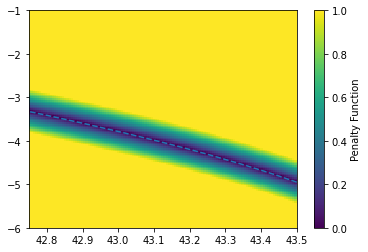

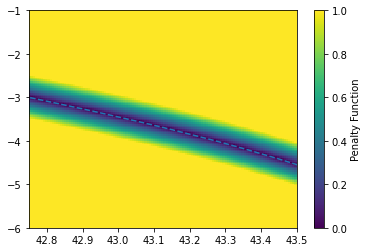

In [25]:
# z = 6.6
penalty_6 = L1PenaltyCalculator(offset=0.5, lower=42.6, upper=43.6)
penalty_6.register_observation(observation_6, log_independent=True, log_dependent=True, independent_units=Lsun, dependent_units=Mpc**-3)
penalty_6.plot_penalty(42.75,43.5,-6,-1,"penalty_example")

all_penalties_6 = penalty_6.penalties(pred_values_6, np.max) # max

all_penalties_array_6 = []
node_number_6 = []
for key in all_penalties_6.keys():
    all_penalties_array_6.append(all_penalties_6[key])
    
    node_number_6.append(key)

print("z=6.6 best fit node = ",node_number_6[np.argmin(all_penalties_array_6)])

# z = 5.5
penalty_5 = L1PenaltyCalculator(offset=0.5, lower=42.6, upper=43.6)
penalty_5.register_observation(observation_5, log_independent=True, log_dependent=True, independent_units=Lsun, dependent_units=Mpc**-3)
penalty_5.plot_penalty(42.75,43.5,-6,-1,"penalty_example")

all_penalties_5 = penalty_5.penalties(pred_values_5, np.max) # max

all_penalties_array_5 = []
node_number_5 = []
for key in all_penalties_5.keys():
    all_penalties_array_5.append(all_penalties_5[key])
    
    node_number_5.append(key)

print("z=5.5 best fit node = ",node_number_5[np.argmin(all_penalties_array_5)])

all_penalties = {}
for key in all_penalties_6.keys():
    all_penalties[key] = (all_penalties_6[key] + all_penalties_5[key]) / 2. # also try max

all_penalties_array = []
node_number = []
for key in all_penalties.keys():
    all_penalties_array.append(all_penalties[key])
    
    node_number.append(key)

print("Best fit node = ",node_number[np.argmin(all_penalties_array)])

best_fit_node = node_number[np.argmin(all_penalties_array)]

In [26]:
from scipy.spatial import cKDTree

n_params = 5
norm_params = np.zeros((len(pred_params), 5))
k = 0
key_dict = {}
for key in pred_params.model_parameters.keys():
    pred_param = pred_params[key]
    log_Mhalo_min = (pred_param['log_Mhalo_min'] - 9.5) / 2.
    log_Mhalo_max = (pred_param['log_Mhalo_max'] - 10.5) / 1.5
    fesc_min = (pred_param['fesc_min'] - 0.05) / 0.35
    a_mu = pred_param['a_mu'] / 2.
    b_mu = (pred_param['b_mu'] - 1.)
    
#     norm_params[k] = np.zeros(5)
    
    norm_params[k][0] = log_Mhalo_min
    norm_params[k][1] = log_Mhalo_max
    norm_params[k][2] = fesc_min
    norm_params[k][3] = a_mu
    norm_params[k][4] = b_mu
    
    key_dict[k] = key
    k += 1
    
tree = cKDTree(data=norm_params)

median_local_penalty = {}

for index in range(len(pred_params)):
    k = 64
    _, neighbours = tree.query(norm_params[index], k=k)

    neighbor_penalties = np.zeros(k)
    for i in range(k):
        key = key_dict[neighbours[i]]
        neighbor_penalties[i] = all_penalties[key]
    
    median_local_penalty[key_dict[index]] = np.median(neighbor_penalties)

best_key, best_value = min(median_local_penalty.items(), key=lambda x: x[1])
print(best_key)

emulated_28391


In [14]:
print(pred_params['emulated_28391'])

{'log_Mhalo_min': 11.017293650670453, 'log_Mhalo_max': 11.341505444517493, 'fesc_min': 0.20783061547221537, 'a_mu': 0.3411603116574622, 'b_mu': 1.4095097573697384}


In [24]:
mp = list(pred_params[best_key].values())
xs_5 = model_values_5[0]['independent']
mask = xs_5 > 41.5
xs_5 = xs_5[mask]

xs_6 = model_values_6[0]['independent']
mask = xs_6 > 41.5
xs_6 = xs_6[mask]

def to_minimize(mp):
    fac = 0.5
    testparams = {'log_Mhalo_min': mp[0], 
                  'log_Mhalo_max': mp[1], 
                  'fesc_min': mp[2], 
                  'a_mu': mp[3], 
                  'b_mu': mp[4]}
    prediction_55, pred_err_55 = LF_emulator_5.predict_values(xs_5, testparams)
    prediction_66, pred_err_66 = LF_emulator_6.predict_values(xs_6, testparams)
#     print(prediction_55)
    
    penalty_55 = penalty_5.penalty(xs_5, prediction_55, pred_err_55)
    penalty_66 = penalty_6.penalty(xs_6, prediction_66, pred_err_66)
#     print(penalty_55)
#     print(penalty_66)
    
    return fac*np.max(penalty_55) + (1.-fac)*np.max(penalty_66)
  
from scipy.optimize import minimize

optresult = minimize(to_minimize, x0=mp, tol=1e-6)

In [25]:
print(optresult.x)

[11.01729365 11.34150544  0.20783062  0.34116031  1.40950976]


In [40]:
print(pred_params[best_key])

{'log_Mhalo_min': 11.017293650670453, 'log_Mhalo_max': 11.341505444517493, 'fesc_min': 0.20783061547221537, 'a_mu': 0.3411603116574622, 'b_mu': 1.4095097573697384}


In [16]:
print(pred_params[best_fit_node])

{'log_Mhalo_min': 10.837630973762424, 'log_Mhalo_max': 11.161975333995223, 'fesc_min': 0.0885061196945787, 'a_mu': 1.9864059062018387, 'b_mu': 1.5668670969766862}


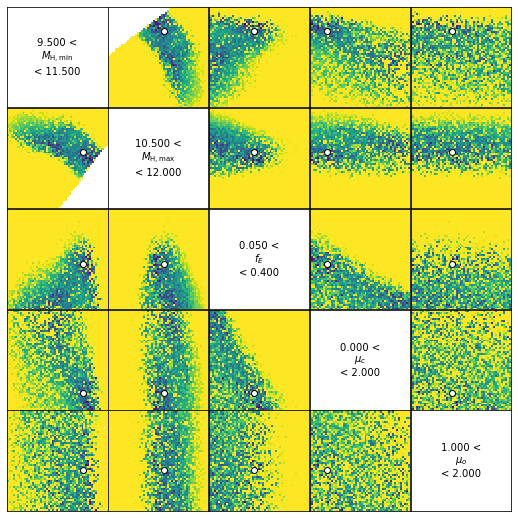

In [15]:
from swiftemulator.comparison.visualisation import visualise_penalties_generic_statistic

fig, ax = visualise_penalties_generic_statistic(model_specification=model_specification, model_parameters=pred_params,
                                      penalties=all_penalties, statistic='min', highlight_model=best_key
)

plt.savefig("5-6comparison/penalty_plot_new.png",dpi=200)
plt.show()

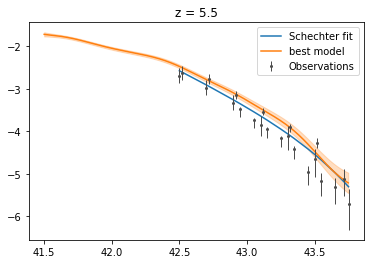

In [15]:
# z = 5.5
# best_key = 'emulated_48473'

# filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/LF_bestfits/LF_5d_s0_080_limittest.hdf5'
# with h5py.File(filename, 'r') as f: 
#     y_avg = f['y_avg_obs'][:].astype(np.float64)
#     y_phi = f['y_phi_obs'][:].astype(np.float64)
#     y_err = f['y_err_obs'][:].astype(np.float64)
# #     mask = (y_avg_gaussian_single > 1e39)
#     y_avg = np.log10(y_avg)
# #     y_phi = y_phi_gaussian_single[mask]
# #     y_err = y_err_gaussian_single[mask]
#     y_low = y_phi-y_err
#     y_high = y_phi+y_err
    
#     y_phi = np.log10(y_phi)
#     y_low = np.log10(y_low)
#     y_high = np.log10(y_high)

#     y_lowdiff = y_phi - y_low
#     y_highdiff = y_high - y_phi
# best_key = 'emulated_13197'
best_model_parameters = pred_params[best_key]
pred_x = pred_values_5[best_key]['independent']
pred_y = pred_values_5[best_key]['dependent']
pred_err = np.sqrt(pred_values_5[best_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

plt.plot(log_L_obs_sorted_5, log_phi_schechter_fit_5, label='Schechter fit', c='C0')
kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'color':[.3,.3,.3], 'zorder':20, 'alpha':1.}
plt.errorbar(log_L_obs_5, log_phi_obs_5, [log_lowdiff_obs_5, log_highdiff_obs_5], **kwargs, marker='o',label='Observations')

plt.plot(pred_x, pred_y, label='best model', c='C1')
plt.fill_between(pred_x, pred_y+3*pred_err, pred_y-3*pred_err, color='C1', alpha=.25)

model_identifiers, closest_parameters = model_parameters_5.find_closest_model(best_model_parameters, 3)
# plt.plot(model_values_5[model_identifiers[0]]['independent'], model_values_5[model_identifiers[0]]['dependent'], label='closest model 1', color='C2')
# plt.fill_between(model_values_5[model_identifiers[0]]['independent'], model_values_5[model_identifiers[0]]['dependent']-3*model_values_5[model_identifiers[0]]['dependent_error'], model_values_5[model_identifiers[0]]['dependent']+3*model_values_5[model_identifiers[0]]['dependent_error'], color='C2', alpha=.25)
# plt.plot(model_values_5[model_identifiers[1]]['independent'], model_values_5[model_identifiers[1]]['dependent'], label='closest model 2', color='C3')
# plt.fill_between(model_values_5[model_identifiers[1]]['independent'], model_values_5[model_identifiers[1]]['dependent']-3*model_values_5[model_identifiers[1]]['dependent_error'], model_values_5[model_identifiers[1]]['dependent']+3*model_values_5[model_identifiers[1]]['dependent_error'], color='C3', alpha=.25)
# plt.plot(model_values_5[model_identifiers[2]]['independent'], model_values_5[model_identifiers[2]]['dependent'], label='closest model 3', color='C4')
# plt.fill_between(model_values_5[model_identifiers[2]]['independent'], model_values_5[model_identifiers[2]]['dependent']-3*model_values_5[model_identifiers[2]]['dependent_error'], model_values_5[model_identifiers[2]]['dependent']+3*model_values_5[model_identifiers[2]]['dependent_error'], color='C4', alpha=.25)

# plt.errorbar(y_avg, y_phi, yerr=[y_lowdiff, y_highdiff], label='best model, real run', c='C5')
# plt.fill_between(y_avg, y_low, y_high, color='C5', alpha=.25)

plt.title('z = 5.5')
plt.legend()
# plt.savefig("5-6comparison/best_fit_comparison_5.png",dpi=200)
plt.show()

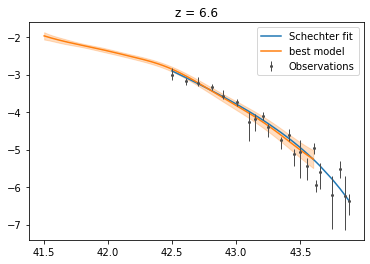

In [16]:
# z = 6.6
# filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/LF_bestfits/LF_5d_s0_060_combined_new.hdf5'
# with h5py.File(filename, 'r') as f: 
#     y_avg = f['y_avg_obs'][:].astype(np.float64)
#     y_phi = f['y_phi_obs'][:].astype(np.float64)
#     y_err = f['y_err_obs'][:].astype(np.float64)
# #     mask = (y_avg_gaussian_single > 1e39)
#     y_avg = np.log10(y_avg)
# #     y_phi = y_phi_gaussian_single[mask]
# #     y_err = y_err_gaussian_single[mask]
#     y_low = y_phi-3*y_err
#     y_high = y_phi+3*y_err
    
#     y_phi = np.log10(y_phi)
#     y_low = np.log10(y_low)
#     y_high = np.log10(y_high)

#     y_lowdiff = y_phi - y_low
#     y_highdiff = y_high - y_phi
# best_key = 'emulated_13197'
best_model_parameters = pred_params[best_key]
pred_x = pred_values_6[best_key]['independent']
pred_y = pred_values_6[best_key]['dependent']
pred_err = np.sqrt(pred_values_6[best_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

plt.plot(log_L_obs_sorted_6, log_phi_schechter_fit_6, label='Schechter fit', c='C0')
kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'color':[.3,.3,.3], 'zorder':20, 'alpha':1.}
plt.errorbar(log_L_obs_6, log_phi_obs_6, [log_lowdiff_obs_6, log_highdiff_obs_6], **kwargs, marker='o',label='Observations')

plt.plot(pred_x, pred_y, label='best model', c='C1')
plt.fill_between(pred_x, pred_y+3*pred_err, pred_y-3*pred_err, color='C1', alpha=.25)

model_identifiers, closest_parameters = model_parameters_6.find_closest_model(best_model_parameters, 3)
# plt.plot(model_values_6[model_identifiers[0]]['independent'], model_values_6[model_identifiers[0]]['dependent'], label='closest model 1', color='C2')
# plt.fill_between(model_values_6[model_identifiers[0]]['independent'], model_values_6[model_identifiers[0]]['dependent']-3*model_values_6[model_identifiers[0]]['dependent_error'], model_values_6[model_identifiers[0]]['dependent']+3*model_values_6[model_identifiers[0]]['dependent_error'], color='C2', alpha=.25)
# plt.plot(model_values_6[model_identifiers[1]]['independent'], model_values_6[model_identifiers[1]]['dependent'], label='closest model 2', color='C3')
# plt.fill_between(model_values_6[model_identifiers[1]]['independent'], model_values_6[model_identifiers[1]]['dependent']-3*model_values_6[model_identifiers[1]]['dependent_error'], model_values_6[model_identifiers[1]]['dependent']+3*model_values_6[model_identifiers[1]]['dependent_error'], color='C3', alpha=.25)
# plt.plot(model_values_6[model_identifiers[2]]['independent'], model_values_6[model_identifiers[2]]['dependent'], label='closest model 3', color='C4')
# plt.fill_between(model_values_6[model_identifiers[2]]['independent'], model_values_6[model_identifiers[2]]['dependent']-3*model_values_6[model_identifiers[2]]['dependent_error'], model_values_6[model_identifiers[2]]['dependent']+3*model_values_6[model_identifiers[2]]['dependent_error'], color='C4', alpha=.25)

# plt.errorbar(y_avg, y_phi, yerr=[y_lowdiff, y_highdiff], label='best model, real run', c='C5')
# plt.fill_between(y_avg, y_low, y_high, color='C5', alpha=.25)

plt.title('z = 6.6')
plt.legend()
# plt.savefig("5-6comparison/best_fit_comparison_6.png",dpi=200)
plt.show()

In [16]:
print(pred_params['emulated_13197'])

{'log_Mhalo_min': 11.217917458438684, 'log_Mhalo_max': 11.22062831047744, 'fesc_min': 0.2029459472958285, 'a_mu': 0.03262467076658848, 'b_mu': 1.0217544207587448}


In [27]:
from swiftemulator import ModelSpecification, ModelParameters
from matplotlib.pyplot import Normalize
from scipy.stats import binned_statistic_2d
from typing import Dict, Optional, Hashable, Iterable, Tuple

def visualise_penalties_generic_statistic(
    model_specification: ModelSpecification,
    model_parameters: ModelParameters,
    penalties: Dict[Hashable, float],
    good_penalty_threshold: float,
    number_of_bins: int,
    statistic: Optional[str] = None,
    norm_statistic: Normalize = Normalize(vmin=0.2, vmax=0.7, clip=True),
    norm_depth: Normalize = Normalize(vmin=0.0, vmax=0.4, clip=True),
#     norm_depth: Normalize = LogNorm(vmin=0.0, vmax=1.0, clip=True),
    cmap_statistic: str = "viridis",
    cmap_depth: str = "inferno",
    ticks_outside: bool = True,
    figsize: Optional[Tuple[float]] = None,
    use_parameters: Optional[Iterable[str]] = None,
    use_colorbar: Optional[bool] = False,
    highlight_model: Optional[Hashable] = None,
) -> Tuple[plt.Figure, Iterable[plt.Axes]]:
    """
    Visualises the penalties using basic binning.
    Parameters
    ----------
    model_specification: ModelSpecification
        The appropriate model specification. Used for the limits
        of the figure.
    model_parameters: ModelParameters
        Parameters of the model, with the appropriate unique IDs.
    penalties: Dict[Hashable, float]
        Penalties for all parameters in ``model_parameters``, with
        the key in this dictionary being the unique IDs.
    good_penalty_threshold: float
        The penalty below which models are considered 'good' and can
        contribute to the depth plot.
    number_of_bins: int
        The number of bins to use for an individual square plot,
        in one dimension.
    statistic: str, optional
        The statistic that you would like to compute. Allowed values
        are the same as for ``scipy.stats.binned_statistic_2d``.
        Defaults to ``mean``.
    norm_statistic: Normalize, optional
        A ``matplotlib`` normalisation object. By default this uses
        ``vmin=0.2`` and ``vmax=0.7``.
    norm_depth: Normalize, optional
        A ``matplotlib`` normalisation object. By default this uses
        ``vmin=0.2`` and ``vmax=0.7``.
    cmap_statistic: str, optional
        The color map to use for the statistic visualisation
    cmap_depth: str, optional
        The color map to use for the depth visualisation
    ticks_outside: bool, optional
        Include ticks on the outside?.
    figsize: Tuple[float], optional
        The figure size to use. Defaults to 7 inches by 7 inches, the
        size for a ``figure*`` in the MNRAS template.
    use_parameters: Iterable[str], optional
        The parameters to include in the figure. If not provided, all
        parameters in the ``model_specification`` are used.
    use_colorbar: Bool, optional
        Include a colorbar? Default: False.
    highlight_model: Hashable, optional
        The model unique ID to highlight. If not provided, no model is
        highlighted.
    Returns
    -------
    fig: Figure
        The figure object.
    axes: np.ndarray[Axes]
        The individual axes.
    Notes
    -----
    You can either change how the figure looks by using the figure
    and axes objects that are returned, or by modifying the
    ``matplotlib`` stylesheet you are currently using.
    """

    if use_parameters is None:
        use_parameters = model_specification.parameter_names

    if figsize is None:
#         if use_colorbar:
#             figsize = (7.0, 7.4)
#         else:
#             figsize = (7.0, 7.0)
        figsize = (7.0, 7.0)

    parameter_indices = [
        model_specification.parameter_names.index(x) for x in use_parameters
    ]

    number_of_parameters = len(use_parameters)
    grid_size = number_of_parameters

    fig, axes_grid = plt.subplots(
        grid_size,
        grid_size,
        figsize=figsize,
        squeeze=True,
        sharex="col",
        sharey="row",
    )

    visualisation_size = 4.0 / np.sqrt(len(model_parameters))
    simulation_ordering = list(model_parameters.keys())

    if highlight_model is not None:
        highlight_index = simulation_ordering.index(highlight_model)

    # Build temporary 1D arrays of parameters/offsets in correct ordering
    ordered_penalties = np.array([penalties[x] for x in simulation_ordering])
    good_model_mask = ordered_penalties < good_penalty_threshold

    limits = model_specification.parameter_limits

    # a thing that I (Clara) shall insert for the purposes of making plots look pretty. comment this out for other plots
    tick0 = [9.5, 10, 10.5, 11, 11.5]
    tick1 = [10.5, 11, 11.5, 12]
    tick2 = [0.1, 0.2, 0.3, 0.4]
    tick3 = [0, 0.5, 1, 1.5, 2]
    tick4 = [1, 1.25, 1.5, 1.75, 2]
    tickks = [tick0, tick1, tick2, tick3, tick4]
    
    label0 = ['', '10', '10.5', '11', '11.5']
    label1 = ['', '11', '11.5', '12']
    label2 = ['0.1', '0.2', '0.3', '0.4']
    label3 = ['', '0.5', '1', '1.5', '']
    label4 = ['1', '1.25', '1.5', '1.75', '2']
    ylabels = [label0, label1, label2, label3, label4]
    
    label0 = ['9.5', '10', '10.5', '11', '11.5']
    label1 = ['', '11', '11.5', '']
    label2 = ['0.1', '0.2', '0.3', '0.4']
    label3 = ['', '0.5', '1', '1.5', '2']
    label4 = ['', '1.25', '1.5', '1.75', '2']
    xlabels = [label0, label1, label2, label3, label4]
    # ok everything afterwards is general
    
    ordered_parameters = [
        np.array(
            [
                model_parameters.model_parameters[x][parameter]
                for x in simulation_ordering
            ]
        )
        for index, parameter in zip(parameter_indices, use_parameters)
    ]

    bins = number_of_bins # int(round(1.0 / number_of_bins))

    statistic = statistic if statistic is not None else "mean"

    # colorbar attempts
    ims = {}
    
    # JB: I am 100% confident in this loop and that we are looping
    # over the correct axes. Do not change this loop.
    for parameter_y, axes_column in zip(parameter_indices, axes_grid):
        for parameter_x, ax in zip(parameter_indices, axes_column):
            if (parameter_y == 0 and parameter_x == 1) or (parameter_x == 0 and parameter_y == 1):
                massx = np.linspace(10, 12, 5)
                massy = massx
                ax.plot(massx, massy, zorder=20, color='orangered')
            
            limits_x = model_specification.parameter_limits[parameter_x]
            limits_y = model_specification.parameter_limits[parameter_y]
            name_x = model_specification.parameter_printable_names[parameter_x]
            name_y = model_specification.parameter_printable_names[parameter_y]

            is_center_line = parameter_x == parameter_y
            do_not_plot = is_center_line

            if do_not_plot:
                ax.text(
                    0.5,
                    0.5,
                    f"{limits_x[0]} <\n{name_x}\n< {limits_x[1]}",
                    transform=ax.transAxes,
                    ha="center",
                    va="center",
                )
            else:
                if parameter_x > parameter_y:
                    bckgrnd = mpl.cm.get_cmap('viridis', 2)
                    ax.set_facecolor(bckgrnd(2))
                    # Your actual statistic
#                     print(ordered_penalties)
#                     print(ordered_parameters[parameter_x])
                    grid, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x],
                        y=ordered_parameters[parameter_y],
                        values=ordered_penalties,
                        statistic=statistic,
                        bins=bins,
                    )
#                     print(xs)
                    im = ax.pcolormesh(
                        xs,
                        ys,
                        grid.T,
                        norm=norm_statistic,
                        cmap=cmap_statistic,
                        rasterized=True,
                    )
                    ims['penalty'] = im
                else:
                    ax.set_facecolor('k')
                    counts_total, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x],
                        y=ordered_parameters[parameter_y],
                        values=ordered_penalties,
                        statistic="count",
                        bins=bins,
                    )
                    counts_good, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x][good_model_mask],
                        y=ordered_parameters[parameter_y][good_model_mask],
                        values=ordered_penalties[good_model_mask],
                        statistic="count",
                        bins=bins,
                    )
#                     print(xs)
                    
                    good_penalty_ratio = counts_good / counts_total
#                     print(good_penalty_ratio)

                    im = ax.pcolormesh(
                        xs,
                        ys,
                        good_penalty_ratio.T,
                        norm=norm_depth,
                        cmap=cmap_depth,
                        rasterized=True,
                    )
                    ims['depth'] = im
    
                # Uncomment me if you don't believe the comment above
                # ax.text(0.5, 0.5, f"x={name_x}\ny={name_y}", transform=ax.transAxes, ha="center", va="center", color="white")

                if highlight_model is not None:
                    highlight_x = ordered_parameters[parameter_x][highlight_index]
                    highlight_y = ordered_parameters[parameter_y][highlight_index]

                    ax.scatter(
                        highlight_x,
                        highlight_y,
                        color="white",
                        edgecolor="black",
                    )

                ax.set_xlim(*limits_x)
                ax.set_ylim(*limits_y)

            if not ticks_outside and (parameter_x != 0 or parameter_y != 0):
                ax.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    left=False,
                    right=False,
                    top=False,
                    labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                )

#                 if is_center_line:
#                     ax.text(
#                         0.5,
#                         0.5,
#                         f"{limits_x[0]} <\n{name_x}tst\n< {limits_x[1]}",
#                         transform=ax.transAxes,
#                         ha="center",
#                         va="center",
#                         fontsize=15,
#                     )
            else:
                ax.set_xticks(tickks[parameter_x])
                ax.set_xticklabels(xlabels[parameter_x])
                ax.set_yticks(tickks[parameter_y])
                ax.set_yticklabels(ylabels[parameter_y])
                ax.set_xlabel(name_x)
                ax.set_ylabel(name_y)

            # Set square in data reference frame
            ax.set_aspect(1.0 / ax.get_data_ratio())

#     print(axes_grid)
    if use_colorbar:
        cax1 = fig.add_axes([1.02, 0.52, 0.07, .48])
        cax1.set_xticks([])
        cax1.set_yticks([])
        cax1.set_axis_off()
        cbar = fig.colorbar(
            ims['penalty'],
            ax=cax1,
            orientation="vertical",
            label=f"Combined penalty along LOS",
            fraction=1
        )
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        
        cax2 = fig.add_axes([1.02, 0, 0.07, .48])
        cax2.set_xticks([])
        cax2.set_yticks([])
        cax2.set_axis_off()
        fig.colorbar(
            ims['depth'],
            ax=cax2,
            orientation="vertical",
            label=f"Viable fraction of parameter space along LOS",
            fraction=1,
            ticks=[0,0.1,0.2,0.3,0.4]
        )

    for a in axes_grid[:-1, :].flat:
        a.set_xlabel(None)
    for a in axes_grid[:, 1:].flat:
        a.set_ylabel(None)

    # As of matplotlib 3.3.4, with a large number of sub-plots this hangs...
    if grid_size > 4:
        fig.constrained_layout = False
        fig.subplots_adjust(0, 0, 1, 1, 0.005, 0.005)

    return fig, axes_grid

In [28]:
print(best_key)

emulated_28391


<ipython-input-27-a4c72c385ca6>:228: RuntimeWarning: divide by zero encountered in true_divide
  good_penalty_ratio = counts_good / counts_total
<ipython-input-27-a4c72c385ca6>:228: RuntimeWarning: invalid value encountered in true_divide
  good_penalty_ratio = counts_good / counts_total


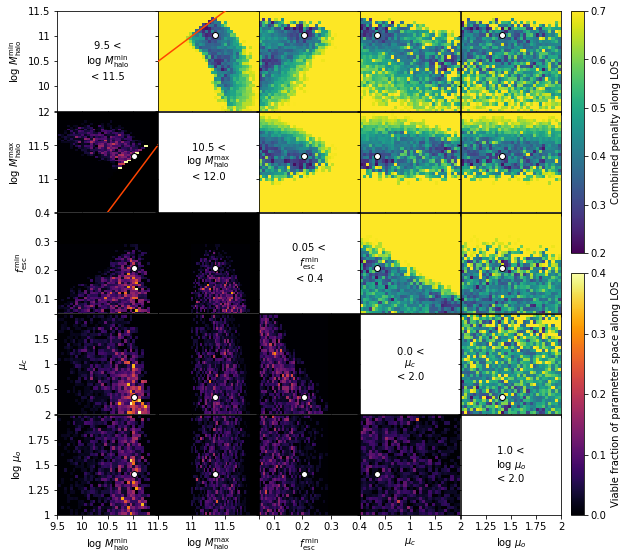

In [29]:
fig, ax = visualise_penalties_generic_statistic(model_specification=model_specification, model_parameters=pred_params,
                                                penalties=all_penalties, good_penalty_threshold=0.6,
                                                number_of_bins=32,
                                                statistic='min', highlight_model=best_key, use_colorbar=True
)

plt.savefig("5-6comparison/penalty_plot_depth_combined.pdf",bbox_inches='tight', transparent=False, dpi=300, pad_inches=0.025)
plt.show()

## Old models, no dust ##

In [12]:
Mpc = 1e6 * pc             # Units: 1 Mpc = 3e24 cm

def read_Lya(snap=70, sim='Thesan-1'):
    print(f'Reading snapshot {snap} ...')
    basePath = f'/nfs/mvogelsblab001/Thesan/{sim}/output'
    fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloVelDisp', 'SubhaloPos', 'SubhaloGrNr']
#     fields = ['SubhaloLenType', 'SubhaloMass', 'SubhaloMassInRadType', 'SubhaloStellarPhotometrics', 'SubhaloStarMetallicity']
#   'SubhaloSFRinRad', 'SubhaloCM', 'SubhaloPos', 'SubhaloVel', 'SubhaloVelDisp']
    s = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    s['snap'] = snap
    s['basePath'] = basePath
    Lya_filename = basePath + f'/../postprocessing/Lya/Lya_{snap:03d}.hdf5'
    with h5py.File(Lya_filename, 'r') as f:
        g = f['Header']
        for key in ['BoxSize', 'EscapeFraction', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'HubbleParam', 'Time', 'Redshift']:
            s[key] = g.attrs[key]
#         BoxSize = g.attrs['BoxSize']
#         EscapeFraction = g.attrs['EscapeFraction']
#         Omega0 = g.attrs['Omega0']
#         OmegaBaryon = g.attrs['OmegaBaryon']
#         OmegaLambda = g.attrs['OmegaLambda']
        h = g.attrs['HubbleParam']
        a = g.attrs['Time']
        z = g.attrs['Redshift']
        UnitLength_in_cm = g.attrs['UnitLength_in_cm']
        UnitMass_in_g = g.attrs['UnitMass_in_g']
        UnitVelocity_in_cm_per_s = g.attrs['UnitVelocity_in_cm_per_s']
        UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
        UnitEnergy_in_cgs = UnitMass_in_g * UnitVelocity_in_cm_per_s * UnitVelocity_in_cm_per_s
        UnitLum_in_cgs = UnitEnergy_in_cgs / UnitTime_in_s
        length_to_cgs = a * UnitLength_in_cm / h
        length_to_kpc = length_to_cgs / kpc
        volume_to_cgs = length_to_cgs * length_to_cgs * length_to_cgs
        s['BoxSize_Mpc'] = s['BoxSize'] * length_to_cgs / Mpc # Box size in Mpc (physical)
        s['V_box_Mpc3'] = s['BoxSize_Mpc']**3 # Box volume in Mpc^3 (physical)
        s['V_box_cMpc3'] = s['V_box_Mpc3'] / s['Time']**3
        mass_to_cgs = UnitMass_in_g / h
        mass_to_Msun = mass_to_cgs / Msun
#         mask = (s['SubhaloLenType'][:,1] >= 0) # No masking
#         mask = ((s['SubhaloMassInRadType'][:,4] > 0. ) &
#                 (s['SubhaloLenType'][:,4] >= 4) &
#                 (s['SubhaloLenType'][:,1] >= 32)) # Minimally resolved
        s['SubhaloMass'] = mass_to_Msun * s['SubhaloMass'] # Msun
#         s['SubhaloMassInRadType'] = mass_to_Msun * s['SubhaloMassInRadType'] # Msun
#         s['SubhaloMassStars'] = mass_to_Msun * s['SubhaloMassInRadType'][:,4] # Msun
#         s['M1450'] = s['SubhaloStellarPhotometrics'][:,0]
        s['Lya'] = UnitLum_in_cgs * f['Subhalo']['LyaLum'][:].astype(np.float64) # Lya = LyaCol + LyaRec + LyaStars
#         s['LyaCol'] = UnitLum_in_cgs * f['Subhalo']['LyaLumCol'][:].astype(np.float64) # erg/s
#         s['LyaRec'] = UnitLum_in_cgs * f['Subhalo']['LyaLumRec'][:].astype(np.float64) # erg/s
#         s['LyaStars'] = UnitLum_in_cgs * f['Subhalo']['LyaLumStars'][:].astype(np.float64) # erg/s
#         s['L1216'] = UnitLum_in_cgs * f['Subhalo']['1216LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['L1500'] = UnitLum_in_cgs * f['Subhalo']['1500LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['L2500'] = UnitLum_in_cgs * f['Subhalo']['2500LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['IonAGN'] = UnitLum_in_cgs * f['Subhalo']['IonLumAGN'][:].astype(np.float64) # erg/s
#         mask = (s['IonAGN'] > 0.)
#         y_AGN = s['IonAGN'][mask] / E_AGN # AGN ionizing photon rate [photons/s]
#         y_stars = s['LyaStars'][mask] / (0.68 * E_Lya * (1. - s['EscapeFraction'])) # Star ionizing photon rate [photons/s]
#         s['f_AGN'] = y_AGN / (y_AGN + y_stars)
# #         for key in ['SubhaloMass', 'SubhaloMassStars', 'Lya', 'LyaCol', 'LyaRec', 'LyaStars', 'L1216', 'L1500', 'L2500', 'IonAGN']:
# #             if key == 'L1500':
# #                 s['SubhaloStarMetallicity'] = s['SubhaloStarMetallicity'][s[key]>0.] / 0.0127 # Solar units
# #             s[key] = s[key][s[key]>0.]
# #         s['M1450'] = s['M1450'][s['M1450']<0.]
#         s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
#         s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
#         s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
#         # Note: z = [6, 7, 8, 9, 10]  =>  dtm = [0.11, 0.08, 0.06, 0.0001, 0.00001]
# #         tau_dust = 1.76e-21 * (1500./1500.)**1.1 * s['SubhaloStarMetallicity'] * (0.11/0.44) * 5e21 #*min(1, max(0, 0.5*(8-zs[isnap])))
# #         s['M1500_dust'] = s['M1500'] - 2.5*np.log10(np.exp(-tau_dust))
# #         s['LyaPos'] = length_to_kpc * f['Subhalo']['LyaPos'][:][mask,:].astype(np.float64) # kpc
# #         s['LyaVel'] = f['Subhalo']['LyaVel'][:][mask,:].astype(np.float64) # km/s
#         s['LyaVelDisp'] = f['Subhalo']['LyaVelDisp'][:][mask].astype(np.float64) # km/s
    
#     otherfields = ['LyaCol', 'LyaRec', 'LyaStars', 'L1216', 'L1500', 'L2500', 'M1216', 'M1500', 'M2500']
    mask = (s['Lya'] > 10**41.5)
    s['Lya'] = s['Lya'][mask]
    for field in fields:
        s[field] = s[field][mask]
#     for field in otherfields:
#         s[field] = s[field][mask]

    # remove high LyaLum values
    mask = (s['Lya'] < 10**45)
    s['Lya'] = s['Lya'][mask]
    for field in fields:
        s[field] = s[field][mask]
#     for field in otherfields:
#         s[field] = s[field][mask]
    
    return s

In [13]:
s5 = read_Lya(snap=80, sim='Thesan-1')
s6 = read_Lya(snap=60, sim='Thesan-1')

Reading snapshot 80 ...
Reading snapshot 60 ...


In [11]:
print(len(s5['Lya']))

20513


In [14]:
def read_x(snap, sim, model, s_lya, dust_model='none'):
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    
    s = {'snap': snap}
    
#     lumcut = s_lya[snap][sim]['M1500']
#     mask = (lumcut < -19)
#     lumcut = np.log10(s_lya[snap][sim]['Lya'])
#     mask = (lumcut > 41)
    
    if dust_model == 'none':
        filename = tau_dir + f'/X/X_{model}_0_{snap:03d}.hdf5'
        with h5py.File(filename, 'r') as f:
            s['X'] = f['X'][:]
#             s['X'] = s['X'][mask]
    else:
        filename = tau_dir + f'/X/X_{model}_0_{snap:03d}_fesc{dust_model}.hdf5'
        with h5py.File(filename, 'r') as f:
            s['X'] = f['X_dust'][:]
#             s['X'] = s['X'][mask]

    # adding in dust
    log_Mhalo_min = 10.883538402319221
    log_Mhalo_max = 11.299095105212213
    fesc_min = 0.18948777032446434
    
    LyaLum = s_lya['Lya']
    n_galaxies = len(LyaLum)
    fesc = np.zeros(n_galaxies)
    halomasses = s_lya['SubhaloMass']
    
    for i in range(n_galaxies):
        halomass = halomasses[i]
        loghalo = np.log10(halomass)
        if loghalo < log_Mhalo_min:
            fesc[i] = 1.
        elif loghalo > log_Mhalo_max:
            fesc[i] = fesc_min
        else:
            fesc[i] = 1. + (loghalo - log_Mhalo_min) * (fesc_min - 1.)/(log_Mhalo_max - log_Mhalo_min) # point slope form
    
    s['X_dust'] = fesc * s['X']
        
    return s

In [15]:
def calc_hist(data, n_0=7, n_max=50000, reverse=True, use_median=True):
    y = np.sort(data)
    if reverse:
        y = y[::-1] # Start from high mass end
    n_y = len(y)
    n_c = n_i = n_0
    n_bins = 1
    while n_c < n_y:
        n_i = min(2 * n_i, n_max, n_y - n_c)
        n_c += n_i
        n_bins += 1
    y_edges = np.zeros(n_bins+1)
    y_avg = np.zeros(n_bins)
    y_num = np.zeros(n_bins)
    y_edges[1] = 0.5 * (y[n_0-1] + y[n_0])
    y_edges[0] = y[0] + (y[n_0-1] - y_edges[1])
    y_avg[0] = np.median(y[0:n_0]) if use_median else np.mean(y[0:n_0])
    y_num[0] = n_0
    if reverse:
        assert y[n_0-1] > y[n_0]
        assert y_edges[0] > y[0]
    else:
        assert y[n_0-1] < y[n_0]
        assert y_edges[0] < y[0]
    n_c = n_i = n_0
    i_bin = 1
    while n_c < n_y:
        n_i = min(2 * n_i, n_max, n_y - n_c)
        y_edges[i_bin] = 0.5 * (y[n_c-1] + y[n_c])
        y_avg[i_bin] = np.median(y[n_c:n_c+n_i]) if use_median else np.mean(y[n_c:n_c+n_i])
        y_num[i_bin] = n_i
        n_c += n_i
        i_bin += 1
    y_edges[-1] = y[-1]
#     if False:
#         y_edges[-2] = y_edges[-1]
#         y_avg[-2] = (y_avg[-2]*y_num[-2] + y_avg[-1]*y_num[-1]) / (y_num[-2] + y_num[-1])
#         y_num[-2] = y_num[-2] + y_num[-1]
#         y_edges = y_edges[:-1]
#         y_avg = y_avg[:-1]
#         y_num = y_num[:-1]
    dy = y_edges[1:] - y_edges[:-1]
    if reverse:
        dy = -dy
#     print(n_bins)
#     print(np.sum(y_num)-n_y)
    return y_avg, y_num/dy, np.sqrt(y_num)/dy

In [23]:
Lya_int_60 = s6['Lya']
Lya_int_80 = s5['Lya']
Lya_ints = {80: Lya_int_80, 60: Lya_int_60}
s = {80: s5, 60: s6}

def calc_lf_sightlines(snap):
    Lya_int = Lya_ints[snap]

    n_bins = 10
    n_sightlines = 768

    y_phis = np.zeros((n_bins, n_sightlines))
    y_errs = np.zeros((n_bins, n_sightlines))
    
    # first sightline, get bins
#     filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/X_emulated/X_emulated_ind_{snap:03d}.hdf5'
    filename = f'/pool001/users/claraxu/Thesan/Thesan-2/tau/Thesan-1_ind/X_emulated/X_emulated_ind_{snap:03d}.hdf5'
    with h5py.File(filename, 'r') as f:
        X = f['Xs'][:, 0]

    Lya_obs = Lya_int * X
    Lya_obs = Lya_obs[Lya_obs>10**41.5]

    y_num, edges = np.histogram(np.log10(Lya_obs), n_bins)
    dy = edges[1:] - edges[:-1]
    y_avg = (edges[1:] + edges[:-1]) / 2
    y_phi = y_num/dy
    y_err = np.sqrt(y_num)/dy
    y_phi /= s[snap]['V_box_cMpc3']; y_err /= s[snap]['V_box_cMpc3']

    y_phis[:, 0] = y_phi
    y_errs[:, 0] = y_err
    
    # rest of them
    for i in range(1, n_sightlines):
        with h5py.File(filename, 'r') as f:
            X = f['Xs'][:, i]

        Lya_obs = Lya_int * X
        Lya_obs = Lya_obs[Lya_obs>10**41.5]
        
        y_num, _ = np.histogram(np.log10(Lya_obs), edges)
        y_phi = y_num/dy
        y_err = np.sqrt(y_num)/dy
        y_phi /= s[snap]['V_box_cMpc3']; y_err /= s[snap]['V_box_cMpc3']
        
        y_phis[:, i] = y_phi
        y_errs[:, i] = y_err
        
    tau_dir = '/pool001/users/claraxu/Thesan/Thesan-2/tau/Thesan-1_ind'
    with h5py.File(f'{tau_dir}/X_emulated/lf_sightlines_ind_{snap:03d}.hdf5', 'w') as f:
        f.create_dataset('y_avg', data=y_avg, dtype=np.float64)
        f.create_dataset('y_phi', data=y_phis, dtype=np.float64)
        f.create_dataset('y_err', data=y_errs, dtype=np.float64)

In [24]:
calc_lf_sightlines(60)

In [19]:
sigma_68 = erf(1./np.sqrt(2.))
percentiles = [50., 50.*(1.-sigma_68), 50.*(1.+sigma_68)]
n_percentiles = len(percentiles)

<ipython-input-25-bd405ef8faa4>:119: RuntimeWarning: divide by zero encountered in log10
  y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs), n_0=20)
<ipython-input-25-bd405ef8faa4>:132: RuntimeWarning: divide by zero encountered in log10
  y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs_dust), n_0=20)
<ipython-input-25-bd405ef8faa4>:155: RuntimeWarning: divide by zero encountered in log10
  ax.plot(y_avg, np.log10(y_phi_50), lw=3., label='Combined best fit', color='k', ls='--')
<ipython-input-25-bd405ef8faa4>:156: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color='k', alpha=.25)
<ipython-input-25-bd405ef8faa4>:172: RuntimeWarning: divide by zero encountered in log10
  ax.plot(y_avg, np.log10(y_phi_50), label='Best fit for the redshift', color=[.3,.3,.3], ls=':')
<ipython-input-25-bd405ef8faa4>:173: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_

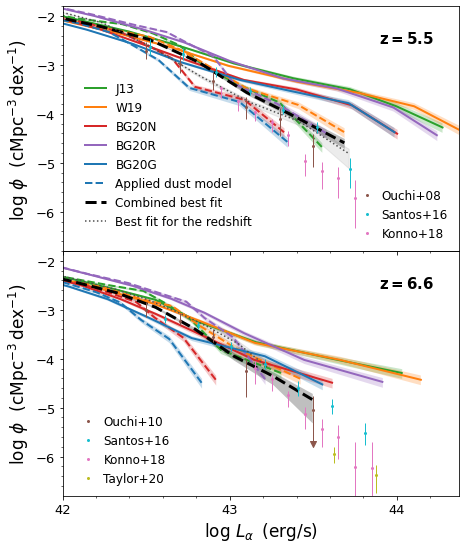

In [25]:
def plot_nodust():
    fig = plt.figure(figsize=[5.5, 3.4])
    
    labels = {'M1': 'BG20G', 'M7': 'W19', 'M8': 'J13', 'M9': 'BG20N', 'M10': 'BG20R'}
    colors = {'M1': 'C0', 'M7': 'C1', 'M8': 'C2', 'M9': 'C3', 'M10': 'C4'}
    
    ### z = 6.6 ###
    ax = plt.axes([0,0,1,1])

    kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'zorder':20, 'alpha':1.}
#     log_ouchi_lowdiff[-1] = log_ouchi_phi-5.75
    p0,_,_ = ax.errorbar(log_ouchi_lum, log_ouchi_phi, [log_ouchi_lowdiff, log_ouchi_highdiff], **kwargs, marker='o', color='C5')
    ax.scatter(log_ouchi_lum[-1], -5.75, zorder=20, alpha=1., marker='v', color='C5')
    p1,_,_ = ax.errorbar(log_santos_lum, log_santos_phi, [log_santos_lowdiff, log_santos_highdiff], **kwargs, marker='o', color='C9')
    p2,_,_ = ax.errorbar(log_konno_lum, log_konno_phi, [log_konno_lowdiff, log_konno_highdiff], **kwargs, marker='o', color='C6')
    p3,_,_ = ax.errorbar(log_taylor_lum, log_taylor_phi, [log_taylor_lowdiff, log_taylor_highdiff], **kwargs, marker='o', color='C8')
    
    # old models
    for model in ['M8', 'M7', 'M9', 'M10', 'M1']:
    # for model in ['M1']:
        sx = read_x(60, 'Thesan-1', model, s6)
        X = sx['X']
        Lya_int = s6['Lya']
        Lya_obs = Lya_int * X

        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs), n_0=20)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s6['V_box_cMpc3']; y_err /= s6['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err

        ax.plot(y_avg, np.log10(y_phi), lw=2., label=labels[model], color=colors[model])
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., alpha=.25, color=colors[model])
        
        # with our dust model applied
        X_dust = sx['X_dust']
        Lya_obs_dust = Lya_int * X_dust

        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs_dust), n_0=20)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s6['V_box_cMpc3']; y_err /= s6['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err

        ax.plot(y_avg, np.log10(y_phi), lw=2., color=colors[model], ls='--')
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., alpha=.25, color=colors[model])
    
    # emulated models
    with h5py.File('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/X_emulated/lf_sightlines_060.hdf5', 'r') as f:
        y_avg = f['y_avg'][:]
        y_phi = f['y_phi'][:,:]
        y_err = f['y_err'][:,:]

    y_phi_p = np.percentile(y_phi, percentiles, axis=1)
    y_phi_50 = y_phi_p[0]
    y_phi_16 = y_phi_p[1]
    y_phi_84 = y_phi_p[2]
    
    ax.plot(y_avg, np.log10(y_phi_50), lw=3., label='Combined best fit', color='k', ls='--')
    ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color='k', alpha=.25)
    
    # 0th sightline
#     ax.plot(y_avg, np.log10(y_phi[:,0]), lw=2., label='Combined fit, sightline 0', color='cyan', ls=':')
    
    # best fit for 6.6, single sightline
    with h5py.File('/pool001/users/claraxu/Thesan/Thesan-2/tau/Thesan-1_ind/X_emulated/lf_sightlines_ind_060.hdf5', 'r') as f:
        y_avg = f['y_avg'][:]
        y_phi = f['y_phi'][:,:]
        y_err = f['y_err'][:,:]

    y_phi_p = np.percentile(y_phi, percentiles, axis=1)
    y_phi_50 = y_phi_p[0]
    y_phi_16 = y_phi_p[1]
    y_phi_84 = y_phi_p[2]
    
    ax.plot(y_avg, np.log10(y_phi_50), label='Best fit for the redshift', color=[.3,.3,.3], ls=':')
    ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), alpha=.1, color=[.3,.3,.3])
    
    # labels and such
    ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$', fontsize=17)
    ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=17)
    
    xmin, xmax = 42, 44.37
    ymin, ymax = -6.8, -1.8
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    Lxmin,Lxmax = int(np.ceil(xmin)), int(np.floor(xmax))
    ticks = [42, 43, 44]
    ax.set_xticks(ticks); ax.set_xticklabels([tick for tick in ticks], fontsize=13)
    
    Lymin,Lymax = int(np.ceil(ymin)), int(np.floor(ymax))
    ticks = [-6, -5, -4, -3, -2]
    ticklabels = ['$-6$', '$-5$', '$-4$', '$-3$', '$-2$']
    ax.set_yticks(ticks); ax.set_yticklabels(ticklabels, fontsize=13)
    
    ax.annotate(r'${\bf z=6.6}$', (.8, 0.85), xycoords='axes fraction', fontsize=15, fontweight='bold')
    ax.legend([p0,p1,p2,p3], ['Ouchi+10', 'Santos+16', 'Konno+18', 'Taylor+20'],
              loc='lower left', frameon=False, borderaxespad=.5, handlelength=2.5, ncol=1, fontsize=12, handletextpad=0.)
    
    ax.minorticks_on()
    
    ### z = 5.5 ###
    ax = plt.axes([0,1,1,1])
    
    p0,_,_ = ax.errorbar(log_ouchi_lum5, log_ouchi_phi5, [log_ouchi_lowdiff5, log_ouchi_highdiff5], **kwargs, marker='o', color='C5')
    p1,_,_ = ax.errorbar(log_santos_lum5, log_santos_phi5, [log_santos_lowdiff5, log_santos_highdiff5], **kwargs, marker='o', color='C9')
    p2,_,_ = ax.errorbar(log_konno_lum5, log_konno_phi5, [log_konno_lowdiff5, log_konno_highdiff5], **kwargs, marker='o', color='C6')
    
    # old models
    for model in ['M8', 'M7', 'M9', 'M10', 'M1']:
        sx = read_x(80, 'Thesan-1', model, s5)
        Lya_int = s5['Lya']
        
        # without dust model
        X = sx['X']
        Lya_obs = Lya_int * X

        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs), n_0=20)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s5['V_box_cMpc3']; y_err /= s5['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err

        ax.plot(y_avg, np.log10(y_phi), lw=2., label=labels[model], color=colors[model])
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., alpha=.25 , color=colors[model])
         
        # with our dust model applied
        X_dust = sx['X_dust']
        Lya_obs_dust = Lya_int * X_dust

        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_obs_dust), n_0=20)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s5['V_box_cMpc3']; y_err /= s5['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err
        
        if model=='M1':
            ax.plot(y_avg, np.log10(y_phi), lw=2., color=colors[model], label='Applied dust model', ls='--')
        else:
            ax.plot(y_avg, np.log10(y_phi), lw=2., color=colors[model], ls='--')
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., alpha=.25, color=colors[model])
    
    # emulated models, sightlines
    with h5py.File('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/X_emulated/lf_sightlines_080.hdf5', 'r') as f:
        y_avg = f['y_avg'][:]
        y_phi = f['y_phi'][:,:]
        y_err = f['y_err'][:,:]

    y_phi_p = np.percentile(y_phi, percentiles, axis=1)
    y_phi_50 = y_phi_p[0]
    y_phi_16 = y_phi_p[1]
    y_phi_84 = y_phi_p[2]
    
    ax.plot(y_avg, np.log10(y_phi_50), lw=3., label='Combined best fit', color='k', ls='--')
    ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color='k', alpha=.25)
    
    # 0th sightline
#     ax.plot(y_avg, np.log10(y_phi[:,0]), lw=2., label='Combined fit, sightline 0', color='cyan', ls=':')
    
    # best fit, single sightline
    with h5py.File('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/X_emulated/lf_sightlines_ind_080.hdf5', 'r') as f:
        y_avg = f['y_avg'][:]
        y_phi = f['y_phi'][:,:]
        y_err = f['y_err'][:,:]

    y_phi_p = np.percentile(y_phi, percentiles, axis=1)
    y_phi_50 = y_phi_p[0]
    y_phi_16 = y_phi_p[1]
    y_phi_84 = y_phi_p[2]
    
    ax.plot(y_avg, np.log10(y_phi_50), label='Best fit for the redshift', color=[.3,.3,.3], ls=':')
    ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), alpha=.1, color=[.3,.3,.3])
    
    # labels and such
    xmin, xmax = 42, 44.37
    ymin, ymax = -6.8, -1.8
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    Lxmin,Lxmax = int(np.ceil(xmin)), int(np.floor(xmax))
    ticks = [42, 43, 44]
    ax.set_xticks(ticks); ax.set_xticklabels([])
    
    ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=17)
    Lymin,Lymax = int(np.ceil(ymin)), int(np.floor(ymax))
    ticks = [-6, -5, -4, -3, -2]
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    ax.annotate(r'${\bf z=5.5}$', (.8, 0.85), xycoords='axes fraction', fontsize=15)
    leg = ax.legend(loc='lower left', frameon=False, borderaxespad=1.5, handlelength=1.7, ncol=1, fontsize=12)
    ax.add_artist(leg)
    ax.legend([p0,p1,p2], ['Ouchi+08', 'Santos+16', 'Konno+18'],
              loc='lower right', frameon=False, borderaxespad=.5, handlelength=2.5, ncol=1, fontsize=12, handletextpad=0.)
    
    ax.minorticks_on()
    
    fig.savefig('../luminosity functions/no_dust_models.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    
plot_nodust()

## Sweeps ##

In [12]:
def read_Lya(snap=70, sim='Thesan-1'):
    print(f'Reading snapshot {snap} ...')
    basePath = f'/nfs/mvogelsblab001/Thesan/{sim}/output'
    fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloVelDisp', 'SubhaloPos', 'SubhaloGrNr']
#     fields = ['SubhaloLenType', 'SubhaloMass', 'SubhaloMassInRadType', 'SubhaloStellarPhotometrics', 'SubhaloStarMetallicity']
#   'SubhaloSFRinRad', 'SubhaloCM', 'SubhaloPos', 'SubhaloVel', 'SubhaloVelDisp']
    s = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    Mpc = 1e6 * pc
    s['snap'] = snap
    s['basePath'] = basePath
    Lya_filename = basePath + f'/../postprocessing/Lya/Lya_{snap:03d}.hdf5'
    with h5py.File(Lya_filename, 'r') as f:
        g = f['Header']
        for key in ['BoxSize', 'EscapeFraction', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'HubbleParam', 'Time', 'Redshift']:
            s[key] = g.attrs[key]
#         BoxSize = g.attrs['BoxSize']
#         EscapeFraction = g.attrs['EscapeFraction']
#         Omega0 = g.attrs['Omega0']
#         OmegaBaryon = g.attrs['OmegaBaryon']
#         OmegaLambda = g.attrs['OmegaLambda']
        h = g.attrs['HubbleParam']
        a = g.attrs['Time']
        z = g.attrs['Redshift']
        UnitLength_in_cm = g.attrs['UnitLength_in_cm']
        UnitMass_in_g = g.attrs['UnitMass_in_g']
        UnitVelocity_in_cm_per_s = g.attrs['UnitVelocity_in_cm_per_s']
        UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
        UnitEnergy_in_cgs = UnitMass_in_g * UnitVelocity_in_cm_per_s * UnitVelocity_in_cm_per_s
        UnitLum_in_cgs = UnitEnergy_in_cgs / UnitTime_in_s
        length_to_cgs = a * UnitLength_in_cm / h
        length_to_kpc = length_to_cgs / kpc
        volume_to_cgs = length_to_cgs * length_to_cgs * length_to_cgs
        s['BoxSize_Mpc'] = s['BoxSize'] * length_to_cgs / Mpc # Box size in Mpc (physical)
        s['V_box_Mpc3'] = s['BoxSize_Mpc']**3 # Box volume in Mpc^3 (physical)
        s['V_box_cMpc3'] = s['V_box_Mpc3'] / s['Time']**3
        mass_to_cgs = UnitMass_in_g / h
        mass_to_Msun = mass_to_cgs / Msun
#         mask = (s['SubhaloLenType'][:,1] >= 0) # No masking
#         mask = ((s['SubhaloMassInRadType'][:,4] > 0. ) &
#                 (s['SubhaloLenType'][:,4] >= 4) &
#                 (s['SubhaloLenType'][:,1] >= 32)) # Minimally resolved
        s['SubhaloMass'] = mass_to_Msun * s['SubhaloMass'] # Msun
#         s['SubhaloMassInRadType'] = mass_to_Msun * s['SubhaloMassInRadType'] # Msun
#         s['SubhaloMassStars'] = mass_to_Msun * s['SubhaloMassInRadType'][:,4] # Msun
#         s['M1450'] = s['SubhaloStellarPhotometrics'][:,0]
        s['Lya'] = UnitLum_in_cgs * f['Subhalo']['LyaLum'][:].astype(np.float64) # Lya = LyaCol + LyaRec + LyaStars
        s['LyaCol'] = UnitLum_in_cgs * f['Subhalo']['LyaLumCol'][:].astype(np.float64) # erg/s
        s['LyaRec'] = UnitLum_in_cgs * f['Subhalo']['LyaLumRec'][:].astype(np.float64) # erg/s
        s['LyaStars'] = UnitLum_in_cgs * f['Subhalo']['LyaLumStars'][:].astype(np.float64) # erg/s
        s['L1216'] = UnitLum_in_cgs * f['Subhalo']['1216LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L1500'] = UnitLum_in_cgs * f['Subhalo']['1500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L2500'] = UnitLum_in_cgs * f['Subhalo']['2500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['IonAGN'] = UnitLum_in_cgs * f['Subhalo']['IonLumAGN'][:].astype(np.float64) # erg/s
        mask = (s['IonAGN'] > 0.)
        y_AGN = s['IonAGN'][mask] / E_AGN # AGN ionizing photon rate [photons/s]
        y_stars = s['LyaStars'][mask] / (0.68 * E_Lya * (1. - s['EscapeFraction'])) # Star ionizing photon rate [photons/s]
        s['f_AGN'] = y_AGN / (y_AGN + y_stars)
#         for key in ['SubhaloMass', 'SubhaloMassStars', 'Lya', 'LyaCol', 'LyaRec', 'LyaStars', 'L1216', 'L1500', 'L2500', 'IonAGN']:
#             if key == 'L1500':
#                 s['SubhaloStarMetallicity'] = s['SubhaloStarMetallicity'][s[key]>0.] / 0.0127 # Solar units
#             s[key] = s[key][s[key]>0.]
#         s['M1450'] = s['M1450'][s['M1450']<0.]
        s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
        s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
        s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
        # Note: z = [6, 7, 8, 9, 10]  =>  dtm = [0.11, 0.08, 0.06, 0.0001, 0.00001]
#         tau_dust = 1.76e-21 * (1500./1500.)**1.1 * s['SubhaloStarMetallicity'] * (0.11/0.44) * 5e21 #*min(1, max(0, 0.5*(8-zs[isnap])))
#         s['M1500_dust'] = s['M1500'] - 2.5*np.log10(np.exp(-tau_dust))
#         s['LyaPos'] = length_to_kpc * f['Subhalo']['LyaPos'][:][mask,:].astype(np.float64) # kpc
#         s['LyaVel'] = f['Subhalo']['LyaVel'][:][mask,:].astype(np.float64) # km/s
        s['LyaVelDisp'] = f['Subhalo']['LyaVelDisp'][:][mask].astype(np.float64) # km/s
    return s

In [13]:
def calc_hist(data, n_0=7, n_max=50000, reverse=True, use_median=True):
    y = np.sort(data)
    if reverse:
        y = y[::-1] # Start from high mass end
    n_y = len(y)
    n_c = n_i = n_0
    n_bins = 1
    while n_c < n_y:
        n_i = min(2 * n_i, n_max, n_y - n_c)
        n_c += n_i
        n_bins += 1
    y_edges = np.zeros(n_bins+1)
    y_avg = np.zeros(n_bins)
    y_num = np.zeros(n_bins)
    y_edges[1] = 0.5 * (y[n_0-1] + y[n_0])
    y_edges[0] = y[0] + (y[n_0-1] - y_edges[1])
    y_avg[0] = np.median(y[0:n_0]) if use_median else np.mean(y[0:n_0])
    y_num[0] = n_0
    if reverse:
        assert y[n_0-1] > y[n_0]
        assert y_edges[0] > y[0]
    else:
        assert y[n_0-1] < y[n_0]
        assert y_edges[0] < y[0]
    n_c = n_i = n_0
    i_bin = 1
    while n_c < n_y:
        n_i = min(2 * n_i, n_max, n_y - n_c)
        y_edges[i_bin] = 0.5 * (y[n_c-1] + y[n_c])
        y_avg[i_bin] = np.median(y[n_c:n_c+n_i]) if use_median else np.mean(y[n_c:n_c+n_i])
        y_num[i_bin] = n_i
        n_c += n_i
        i_bin += 1
    y_edges[-1] = y[-1]
#     if False:
#         y_edges[-2] = y_edges[-1]
#         y_avg[-2] = (y_avg[-2]*y_num[-2] + y_avg[-1]*y_num[-1]) / (y_num[-2] + y_num[-1])
#         y_num[-2] = y_num[-2] + y_num[-1]
#         y_edges = y_edges[:-1]
#         y_avg = y_avg[:-1]
#         y_num = y_num[:-1]
    dy = y_edges[1:] - y_edges[:-1]
    if reverse:
        dy = -dy
#     print(n_bins)
#     print(np.sum(y_num)-n_y)
    return y_avg, y_num/dy, np.sqrt(y_num)/dy

Reading snapshot 60 ...


<ipython-input-12-28a850683b43>:64: RuntimeWarning: divide by zero encountered in log10
  s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
<ipython-input-12-28a850683b43>:65: RuntimeWarning: divide by zero encountered in log10
  s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
<ipython-input-12-28a850683b43>:66: RuntimeWarning: divide by zero encountered in log10
  s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
<ipython-input-17-c8bd66eeaeb6>:23: RuntimeWarning: divide by zero encountered in log10
  y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=20)
<ipython-input-13-2e913e10d23f>:42: RuntimeWarning: invalid value encountered in subtract
  dy = y_edges[1:] - y_edges[:-1]
<ipython-input-17-c8bd66eeaeb6>:27: RuntimeWarning: divide by zero encountered in log10
  y_avg = np.log10(y_avg)
<ipython-input-17-c8bd66eeaeb6>:28: RuntimeWarning: divide b

[46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Reading snapshot 80 ...


<ipython-input-12-28a850683b43>:64: RuntimeWarning: divide by zero encountered in log10
  s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
<ipython-input-12-28a850683b43>:65: RuntimeWarning: divide by zero encountered in log10
  s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
<ipython-input-12-28a850683b43>:66: RuntimeWarning: divide by zero encountered in log10
  s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
<ipython-input-17-c8bd66eeaeb6>:134: RuntimeWarning: divide by zero encountered in log10
  y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=20)
<ipython-input-13-2e913e10d23f>:42: RuntimeWarning: invalid value encountered in subtract
  dy = y_edges[1:] - y_edges[:-1]
<ipython-input-17-c8bd66eeaeb6>:138: RuntimeWarning: divide by zero encountered in log10
  y_avg = np.log10(y_avg)
<ipython-input-17-c8bd66eeaeb6>:139: RuntimeWarning: divid

[46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


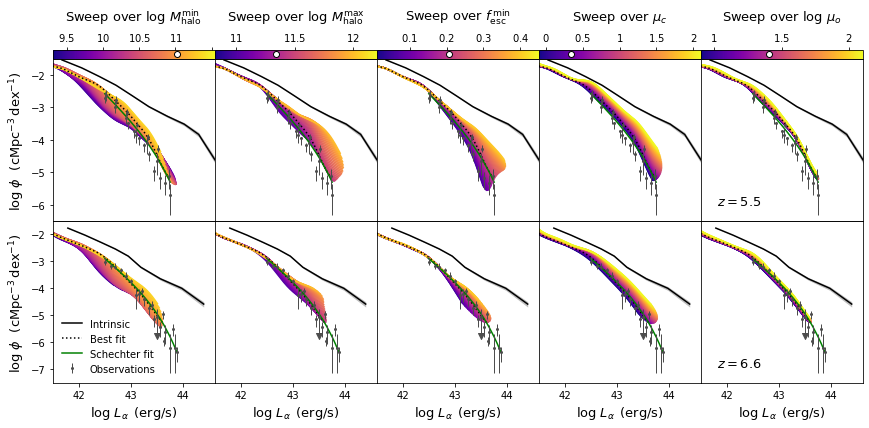

In [17]:
from swiftemulator.mocking import mock_sweep

# combined center
combined_key = 'emulated_28391'
center = pred_params[combined_key]

n_params = 5
dax = 1.5
fax = 1.5 / float(n_params)
fig = plt.figure(figsize=(5.*dax,dax))

# z = 6.6, snap 60
pred_x = pred_values_6[combined_key]['independent']
pred_y = pred_values_6[combined_key]['dependent']
pred_err = np.sqrt(pred_values_6[combined_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

s = read_Lya(snap=60, sim='Thesan-1')

y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=20)
y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
y_avg = 10.**y_avg; y_phi /= s['V_box_cMpc3']; y_err /= s['V_box_cMpc3']; # Volume normalization

y_avg = np.log10(y_avg)
y_low = np.log10(y_phi-y_err)
y_high = np.log10(y_phi+y_err)
y_phi = np.log10(y_phi)

mask = (y_avg > 41.5)
y_avg = y_avg[mask]
y_low = y_low[mask]
y_high = y_high[mask]
y_phi = y_phi[mask]

for j in range(n_params):
    ax = plt.axes([float(j)*fax,0.,fax,1.5])
#     ax = plt.axes([float(j)*fax,0.,fax,1.6])

    param = model_specification.parameter_names[j]

    param_lims = model_specification.parameter_limits[j]
    param_min = param_lims[0]
    param_max = param_lims[1]
    if param == "log_Mhalo_min":
        param_max = center['log_Mhalo_max']
    if param == "log_Mhalo_max":
        param_min = center['log_Mhalo_min']
    
    n_sweeps = 50

    Mock_values, Mock_parameters = mock_sweep(LF_emulator_6,model_specification,n_sweeps,param,center)
    if param == "log_Mhalo_min" or param == "log_Mhalo_max":
        badindices = []
        for k in range(len(Mock_parameters)):
            mp = Mock_parameters['emulated_'+str(k)]
            if mp['log_Mhalo_min'] > mp['log_Mhalo_max']:
                badindices.append(k)
        print(badindices)
        for index in badindices:
            Mock_parameters.model_parameters.pop('emulated_'+str(index))
            Mock_values.model_values.pop('emulated_'+str(index))

    if j==1 or j==0:
        c = np.linspace(param_min,param_max,len(Mock_values))
        param_min -= 0.2
        param_max += 0.2
    elif j==2:
        c = np.linspace(param_min,param_max,len(Mock_values))
        param_min -= 0.04
        param_max += 0.05
    else:
        c = np.linspace(param_min-0.1,param_max+0.1,len(Mock_values))
        param_min -= 0.1
        param_max += 0.1

    norm = mpl.colors.Normalize(vmin=param_min, vmax=param_max)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
    cmap.set_array([])
    
    for i in range(len(Mock_values.keys())):
        mock_name = list(Mock_values.keys())[i]
        mock_x = Mock_values[mock_name]["independent"]
        mock_y = Mock_values[mock_name]["dependent"]
        mock_err = np.sqrt(Mock_values[mock_name]["dependent_error"])
        mask = mock_err < 0.08
        mock_x = mock_x[mask]
        mock_y = mock_y[mask]
        mock_err = mock_err[mask]
        ax.plot(mock_x,
                mock_y,
    #             label = str(Mock_parameters[mock_name]["fesc_min"])[:4],
                color=cmap.to_rgba(c[i]))

    ax.fill_between(y_avg, y_low, y_high, lw=0., color='k', alpha=.25)
    ax.plot(y_avg, y_phi, c='k', label='Intrinsic')
    
    ax.plot(pred_x, pred_y, label='Best fit', c='k', ls=':')
    
    
    ax.plot(log_L_obs_sorted_6, log_phi_schechter_fit_6, label='Schechter fit', c='green')
    
    kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'color':[.3,.3,.3], 'zorder':20, 'alpha':1.}
    ax.errorbar(log_L_obs_6, log_phi_obs_6, [log_lowdiff_obs_6, log_highdiff_obs_6], **kwargs, marker='o',label='Observations')
    ax.scatter(log_ouchi_lum[-1], -5.75, zorder=20, alpha=1., marker='v', color=[.3,.3,.3])
    
    if j==0:
        ax.legend(frameon=False)
        ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=13)
    if j!=0:
        ax.set_yticks([])
    ax.set_xlim([41.5, 44.6])
    ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$', fontsize=13)
    
    ax.set_ylim([-7.5, -1.5])
    
    if j==4:
        ax.annotate('$z=6.6$', (0.1, 0.1), xycoords='axes fraction', fontsize=13)
#     ax.set_title('Sweep over ' + model_specification.parameter_printable_names[j], y=1.2)
    
# z = 5.5, snap 80
pred_x = pred_values_5[combined_key]['independent']
pred_y = pred_values_5[combined_key]['dependent']
pred_err = np.sqrt(pred_values_5[combined_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

s = read_Lya(snap=80, sim='Thesan-1')

y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=20)
y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
y_avg = 10.**y_avg; y_phi /= s['V_box_cMpc3']; y_err /= s['V_box_cMpc3']; # Volume normalization

y_avg = np.log10(y_avg)
y_low = np.log10(y_phi-y_err)
y_high = np.log10(y_phi+y_err)
y_phi = np.log10(y_phi)

mask = (y_avg > 41.5)
y_avg = y_avg[mask]
y_low = y_low[mask]
y_high = y_high[mask]
y_phi = y_phi[mask]

for j in range(n_params):
    ax = plt.axes([float(j)*fax,1.5,fax,1.5])
#     ax = plt.axes([float(j)*fax,0.,fax,1.6])

    param = model_specification.parameter_names[j]

    param_lims = model_specification.parameter_limits[j]
    param_min = param_lims[0]
    param_max = param_lims[1]
    if param == "log_Mhalo_min":
        param_max = center['log_Mhalo_max']
    if param == "log_Mhalo_max":
        param_min = center['log_Mhalo_min']
    
    n_sweeps = 50
    
    Mock_values, Mock_parameters = mock_sweep(LF_emulator_5,model_specification,n_sweeps,param,center)
    if param == "log_Mhalo_min" or param == "log_Mhalo_max":
        badindices = []
        for k in range(len(Mock_parameters)):
            mp = Mock_parameters['emulated_'+str(k)]
            if mp['log_Mhalo_min'] > mp['log_Mhalo_max']:
                badindices.append(k)
        print(badindices)
        for index in badindices:
            Mock_parameters.model_parameters.pop('emulated_'+str(index))
            Mock_values.model_values.pop('emulated_'+str(index))

    if j==1 or j==0:
        c = np.linspace(param_min,param_max,len(Mock_values))
        param_min -= 0.2
        param_max += 0.2
    elif j==2:
        c = np.linspace(param_min,param_max,len(Mock_values))
        param_min -= 0.04
        param_max += 0.05
    else:
        c = np.linspace(param_min-0.1,param_max+0.1,len(Mock_values))
        param_min -= 0.1
        param_max += 0.1

    norm = mpl.colors.Normalize(vmin=param_min, vmax=param_max)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
    cmap.set_array([])        
    
    for i in range(len(Mock_values.keys())):
        mock_name = list(Mock_values.keys())[i]
        mock_x = Mock_values[mock_name]["independent"]
        mock_y = Mock_values[mock_name]["dependent"]
        mock_err = np.sqrt(Mock_values[mock_name]["dependent_error"])
        mask = mock_err < 0.08
        mock_x = mock_x[mask]
        mock_y = mock_y[mask]
        mock_err = mock_err[mask]
        ax.plot(mock_x,
                mock_y,
    #             label = str(Mock_parameters[mock_name]["fesc_min"])[:4],
                color=cmap.to_rgba(c[i]))
    
    # colorbar
    cbarlabels = {'log_Mhalo_min': [r'$9.5$', r'$10$', r'$10.5$', r'$11$', ''],
              'log_Mhalo_max': [r'$11$', r'$11.5$', r'$12$'],
              'fesc_min': [r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$'],
              'a_mu': [r'$0$', r'$0.5$', r'$1$', r'$1.5$', r'$2$'],
              'b_mu': [r'$1$', r'$1.5$', r'$2$']}
    cbarticks = {'log_Mhalo_min': [9.5, 10, 10.5, 11, 11.5],
              'log_Mhalo_max': [11, 11.5, 12],
              'fesc_min': [0.1, 0.2, 0.3, 0.4],
              'a_mu': [0, 0.5, 1, 1.5, 2],
              'b_mu': [1, 1.5, 2]}
    cax = fig.add_axes([float(j)*fax, 3, fax, .08])
    cbar = fig.colorbar(cmap, cax=cax, orientation='horizontal', ticks=cbarticks[model_specification.parameter_names[j]])
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xticklabels(cbarlabels[model_specification.parameter_names[j]])
    bottom, top = cbar.ax.get_ylim()
    cbar.ax.scatter(center[param], (bottom+top)/2, color="white", edgecolor="black")
#     cbar.ax.set_xticks(cbarticks[model_specification.parameter_names[j]])

    ax.fill_between(y_avg, y_low, y_high, lw=0., color='k', alpha=.25)
    ax.plot(y_avg, y_phi, c='k', label='Intrinsic')
    
    ax.plot(pred_x, pred_y, label='Best fit', c='k', ls=':')
    
    
    ax.plot(log_L_obs_sorted_5, log_phi_schechter_fit_5, label='Schechter fit', c='green')
    
    kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'color':[.3,.3,.3], 'zorder':20, 'alpha':1.}
    ax.errorbar(log_L_obs_5, log_phi_obs_5, [log_lowdiff_obs_5, log_highdiff_obs_5], **kwargs, marker='o',label='Observations')
    if j==0:
#         ax.legend(frameon=False)
        ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=13)
    if j!=0:
        ax.set_yticks([])
    ax.set_xlim([41.5, 44.6])
    ax.set_xticks([])
#     ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$')
    
    ax.set_ylim([-6.5, -1.5])
    
    if j==4:
        ax.annotate('$z=5.5$', (0.1, 0.1), xycoords='axes fraction', fontsize=13)
    ax.set_title('Sweep over ' + model_specification.parameter_printable_names[j], y=1.2, fontsize=13)
    
fig.savefig("5-6comparison/fancysweep.pdf",bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
plt.show()